# Determine solution of quantum graph solver and comparison to FVM solution

## Load modules and necessary functions

In [25]:
#import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

import jax.numpy as jnp
from jax import random, vmap
import numpy as np

import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='true'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.6'

import sys
from src.graph import Example0, Example1, Example2, Example3, Example4, Example5, Example6, Example7, Example8, Example7Ext, Example7Ext2
from src.quantumGraphSolverFVM import QuantumGraphSolverFVM
from src.dataHandling import load_final_model, load_best_model
from src.networks_velocity import modified_MLP, MLP, FF_MLP, PI_DeepONet
from src.GPs import get_sample_fns, RBF

import pickle
from datetime import datetime
import jax
import optax

from jax.example_libraries import optimizers


## Set up global parameters

In [26]:
FVM_NT = 2000
FVM_NX = 1000

# Choose an appropriate FVM_NX
assert FVM_NX % 100 == 0
fnx = round(FVM_NX/100)
assert FVM_NT % 100 == 0
fnt = round(FVM_NT/100)


EPS = 0.1

N_DATA_BC = 100
N_DATA_INIT = 100

x_sensor_bc = jnp.linspace(0, 1, N_DATA_BC+1)
x_sensor_init = jnp.linspace(0, 1, N_DATA_INIT+1)
n_sensor_bc =  N_DATA_BC+1
n_sensor_init = N_DATA_INIT+1

# Locations of residual values inside domain
T_RES, X_RES = jnp.meshgrid(jnp.linspace(0, 1, FVM_NT + 1),
                            jnp.linspace(0, 1, FVM_NX + 1))

TX = jnp.hstack([T_RES.reshape((-1,1)), X_RES.reshape((-1,1))])
TX_small = jnp.hstack([l.reshape((-1, 1)) for l in jnp.meshgrid(
    jnp.linspace(0, 1, N_DATA_BC + 1),
    jnp.linspace(0, 1, N_DATA_INIT + 1))])

# Change GP parameters to avoid inverse crime, original values
# LENGTH_SCALE = 0.5 # original
# N = 512 # original
LENGTH_SCALE = 0.4
N = 468

sample_u_in_fn, sample_u_out_fn, sample_u_init_fn = get_sample_fns(N=N, length_scale=LENGTH_SCALE)


def fvm_solve(graph, nx=200, nt = 1000):
    fvm_solver = QuantumGraphSolverFVM(graph)
    v = fvm_solver.solve(nx=nx + 1, nt=nt + 1)
    v0 = np.array([fvm_solver.get_u_edge(v.T, i).T for i in range(graph.ne)])
    return v0

def draw_random_velocity(graph, key, vmin=0.5, vmax=2.):
    v_current = graph.v
    return random.uniform(key, v_current.shape, minval=vmin, maxval=vmax)

# Prepare certain time-space points where model is evaluated
N = 100
tx_in = jnp.hstack([jnp.linspace(0, 1, N + 1)[:, None], jnp.ones((N + 1, 1))])
tx_out = jnp.hstack([jnp.linspace(0, 1, N + 1)[:, None], jnp.zeros((N + 1, 1))])

# Prepare certain time-space points where model is evaluated
n_rnd = 200
tx_rnd = random.uniform(random.key(1),(n_rnd,2))
tx_mid = jnp.hstack([jnp.linspace(0, 1, N + 1)[:, None], .5*jnp.ones((N + 1, 1))])


## Load model parameters for PI DeepONet model

In [27]:
# These parameters are investigated
#N_WIDTH, MODE = 100, 0
#N_WIDTH, MODE = 100, 1
#N_WIDTH, MODE = 100, 2
#N_WIDTH, MODE = 200, 0
#N_WIDTH, MODE = 200, 1
N_WIDTH, MODE = 200, 2

FLOW_APPROACH = 'rbf'
#FLOW_APPROACH = 'poly'

SOLVER_N_ITER = 5000
L2_abs_loss = []
L2_rel_loss = []
Linf_loss = []
Loss_sum = []
Loss_flux = []
Loss_cont = []

# We evaluate the inference error for the following example
# Various test settings are implemented, feel free to define your
# own examples in src.graph

mode= 2
if mode == 0:
    graph = Example2(eps=EPS)
if mode == 1:
    graph = Example5(eps=EPS, n_edges=3)
if mode == 2:
    graph = Example7(eps=EPS)
elif mode == 3:
    n_in = 3
    n_out = 3
    graph = Example7Ext2(n=34*3, n_in = n_in, n_out=n_out, eps=EPS)
elif mode == 5:
    n_in = 5
    n_out = 5
    graph = Example7Ext2(n=34*5, n_in = n_in, n_out=n_out, eps=EPS)
elif mode == 10:
    n_in = 5
    n_out = 5
    graph = Example7Ext2(n=34*10, n_in = n_in, n_out=n_out, eps=EPS)

m = 304

params_inflow, params_inner, params_outflow = load_best_model(N_WIDTH, MODE, prefix='.')

# Initialize model
branch_layers = [m, N_WIDTH, N_WIDTH, N_WIDTH, N_WIDTH, N_WIDTH, N_WIDTH, N_WIDTH]
trunk_layers =  [2, N_WIDTH, N_WIDTH, N_WIDTH, N_WIDTH, N_WIDTH, N_WIDTH, N_WIDTH]
model = PI_DeepONet(Example0(eps=EPS), branch_layers, trunk_layers, trunk_net=FF_MLP)

Loaded  ./final_params/params_inflow_mode_2_width_200_split_8_epochs_20000_loss_6.64e-04_FF_best_01-28-2025-163740_FF.pkl
Loaded  ./final_params/params_inner_mode_2_width_200_split_8_epochs_20000_loss_2.62e-04_FF_best_01-29-2025-074810_FF.pkl
Loaded  ./final_params/params_outflow_mode_2_width_200_split_8_epochs_20000_loss_6.30e-04_FF_best_01-29-2025-041253_FF.pkl


## Plot adjacency matrix of graph

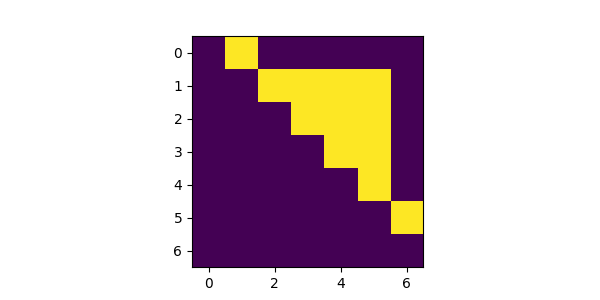

In [28]:
fig = plt.figure(figsize=(6,3))
plt.imshow(graph.A)

## Plot graph

Text(0.5, 1.0, 'Graph with 12 edges, 1 inflow and 1 outflow nodes')

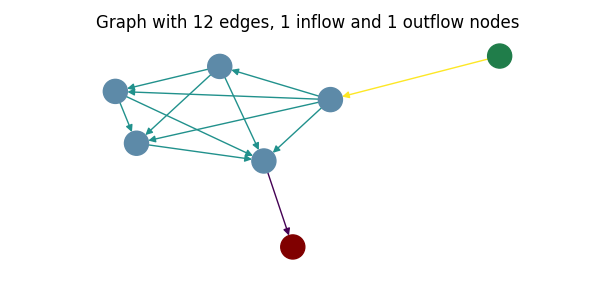

In [29]:
fig = plt.figure(figsize=(6,3))
n_in = len(graph.inflowNodes)
n_out = len(graph.outflowNodes)
sfig = f'Graph with {graph.ne} edges, {n_in} inflow and {n_out} outflow nodes';
ax = plt.gca()
graph.plotGraph(ax=ax)
ax.set_title(sfig)


In [30]:
print(f'Graph has {graph.ne} edges and {graph.n_v} vertices')

Graph has 12 edges and 7 vertices


## Prepare solution on graph

### Determine vertex-edge connectivity table

In [31]:
# Vertex-edge list
vertex_edge_list = []
glob_inner_idx = 0
for vidx in graph.innerVertices:
    for eidx in graph.Vin[vidx]: # Incoming edges in vertex vidx
        #print(f'Incoming edge {eidx} into vertex {vidx} is a ')
        if graph.E[eidx][0] in graph.inflowNodes:
            #print(f'\t INFLOW EDGE')
            vertex_edge_list.append([vidx, glob_inner_idx, eidx, -1, -1])
        else:
            #print(f'\t INNER EDGE')
            vertex_edge_list.append([vidx, glob_inner_idx, eidx, -1, 0])
    for eidx in graph.Vout[vidx]: # Outflowing edges from vertex vidx
        #print(f'Outgoing edge {eidx} from vertex {vidx} is a ')
        if graph.E[eidx][1] in graph.outflowNodes:
            #print(f'\t OUTFLOW EDGE')
            vertex_edge_list.append([vidx, glob_inner_idx, eidx, 1, 1])
        else:
            #print(f'\t INNER EDGE')
            vertex_edge_list.append([vidx, glob_inner_idx, eidx, 1, 0])
    glob_inner_idx += 1
vertex_edge_list = np.vstack(vertex_edge_list)
n_params = vertex_edge_list.shape[0]

# Inner vertex index -> vertex-edge list index
ve_vidx = []
for vidx in range(len(graph.innerVertices)):
    ve_vidx.append(jnp.argwhere(vertex_edge_list[:,1] == vidx).flatten())

# Edge list
edge_list = []
inner_idx = 0

for i, e in enumerate(graph.E): # All edges
    #print(f'Edge {e} is a ')
    inflow_idx = np.where(e[0] == graph.inflowNodes)[0]
    outflow_idx = np.where(e[1] == graph.outflowNodes)[0]
    if len(inflow_idx) > 0:
        #print(f'\t INFLOW EDGE')
        edge_list.append([i, inflow_idx[0], *e, -1])
    elif len(outflow_idx) > 0:
        #print(f'\t OUTFLOW EDGE')
        edge_list.append([i, outflow_idx[0], *e, 1])
    else:
        #print(f'\t INNER EDGE')
        edge_list.append([i, inner_idx, *e, 0])
        inner_idx += 1
edge_list = np.vstack(edge_list)

n_inflow_edges = np.sum(edge_list[:,-1]==-1)
n_outflow_edges = np.sum(edge_list[:,-1]==1)
n_inner_edges = np.sum(edge_list[:,-1]==0)

### Polynomial and RBF approach for flows

In [32]:
if FLOW_APPROACH == 'poly':
    # beta are the coefficients of some polynomial (power, Chebyshev, etc.)
    deg_flow = 3
    def draw_initial_beta(key):
        return random.normal(key, shape=(n_params, deg_flow + 1)) * 0.01
    

    def beta_to_z_flow(beta):
        return jnp.vstack([jnp.polyval(b, x_sensor_bc).reshape((1,101)) for b in beta])
    
    print(f'Beta to z_flow shape: {beta_to_z_flow(beta).shape}')
    
elif FLOW_APPROACH == 'rbf':

    # Parameters for RBF interpolation
    n_rbf_flow = 10
    
    rbf_output_scale = 1.
    rbf_length_scale = 0.2
    rbf_jitter = 1e-10
    
    def draw_initial_beta(key):
        return random.normal(key, shape=(n_params, n_rbf_flow)) * 0.01
    
    
    x_rbf_flow = jnp.linspace(0, 1, n_rbf_flow)
    K_flow = RBF(x_sensor_bc.reshape((n_sensor_bc, 1)),
                 x_rbf_flow.reshape((-1, 1)),
                 (rbf_output_scale, rbf_length_scale))
    
    def beta_to_z_flow(beta):
        return jnp.vstack([jnp.dot(K_flow, b).reshape((1, n_sensor_bc)) for b in beta])
        
    plot_samples = False
    if plot_samples:
        fig = plt.figure(clear=True)
        ax = fig.add_subplot(1,1,1)
        #fig, ax = plt.subplots(1,2, subplot_kw={'clear':True})
        ax.plot(x_sensor_bc, beta_to_z_flow(beta).T)
        #ax[1].plot(x_sensor_init, gamma_to_z_init(gamma).T)

## Prepare quantities to efficiently evaluate model

In [33]:
# Prepare evaluation of measurement data
predict_all = vmap(model.flux_net, (None, None, 0, 0))
predict_flux = vmap(predict_all, (None, 0, None, None))

incoming_inflow_idx = jnp.where(vertex_edge_list[:, -1] == -1)[0]
incoming_inner_idx = jnp.where((vertex_edge_list[:, -1] == 0) * (vertex_edge_list[:, 3] == -1))[0]
outgoing_inner_idx = jnp.where((vertex_edge_list[:, -1] == 0) * (vertex_edge_list[:, 3] == 1))[0]
outgoing_outflow_idx = jnp.where(vertex_edge_list[:, -1] == +1)[0]

# Prepare evaluation of vertex-edge data
n_ve = vertex_edge_list.shape[0]
n_tx = tx_in.shape[0]

ve_incoming_inflow = vertex_edge_list[incoming_inflow_idx, :]
ve_incoming_inner = vertex_edge_list[incoming_inner_idx, :]
ve_outgoing_inner = vertex_edge_list[outgoing_inner_idx, :]
ve_outgoing_outflow = vertex_edge_list[outgoing_outflow_idx, :]

n_incoming_inflow = ve_incoming_inflow.shape[0]
n_incoming_inner = ve_incoming_inner.shape[0]
n_outgoing_inner = ve_outgoing_inner.shape[0]
n_outgoing_outflow = ve_outgoing_outflow.shape[0]

def predict_ve_incoming_inflow(z):
    f, v = jnp.split(jnp.stack(predict_flux(params_inflow, z[ve_incoming_inflow[:, 2],:], tx_in[:, 0], tx_in[:, 1])), 2)
    return f.squeeze(axis=0) * ve_incoming_inflow[:, 3].reshape((-1,1)), v.squeeze(axis=0)
    
def predict_ve_incoming_inner(z):
    f, v = jnp.split(jnp.stack(predict_flux(params_inner, z[ve_incoming_inner[:, 2],:], tx_in[:, 0], tx_in[:, 1])), 2)
    return f.squeeze(axis=0) * ve_incoming_inner[:, 3].reshape((-1,1)), v.squeeze(axis=0)
    
def predict_ve_outgoing_inner(z):
    f, v = jnp.split(jnp.stack(predict_flux(params_inner, z[ve_outgoing_inner[:, 2],:], tx_out[:, 0], tx_out[:, 1])), 2)
    return f.squeeze(axis=0) * ve_outgoing_inner[:, 3].reshape((-1,1)), v.squeeze(axis=0)
    
def predict_ve_outgoing_outflow(z):
    f, v = jnp.split(jnp.stack(predict_flux(params_outflow, z[ve_outgoing_outflow[:, 2],:], tx_out[:, 0], tx_out[:, 1])), 2)
    return f.squeeze(axis=0) * ve_outgoing_outflow[:, 3].reshape((-1,1)), v.squeeze(axis=0)

### Define loss function for inference

In [34]:
def f_u_new(u_base):
    ve_incoming_inflow_flux, ve_incoming_inflow_vals = predict_ve_incoming_inflow(u_base)
    ve_incoming_inner_flux, ve_incoming_inner_vals = predict_ve_incoming_inner(u_base)
    ve_outgoing_inner_flux, ve_outgoing_inner_vals = predict_ve_outgoing_inner(u_base)
    ve_outgoing_outflow_flux, ve_outgoing_outflow_vals = predict_ve_outgoing_outflow(u_base)
    
    Xvals = jnp.empty((n_ve, n_tx))
    Xvals = Xvals.at[incoming_inflow_idx].set(ve_incoming_inflow_vals)
    Xvals = Xvals.at[incoming_inner_idx].set(ve_incoming_inner_vals)
    Xvals = Xvals.at[outgoing_inner_idx].set(ve_outgoing_inner_vals)
    Xvals = Xvals.at[outgoing_outflow_idx].set(ve_outgoing_outflow_vals)
    
    Xflux = jnp.empty((n_ve, n_tx))
    Xflux = Xflux.at[incoming_inflow_idx].set(ve_incoming_inflow_flux)
    Xflux = Xflux.at[incoming_inner_idx].set(ve_incoming_inner_flux)
    Xflux = Xflux.at[outgoing_inner_idx].set(ve_outgoing_inner_flux)
    Xflux = Xflux.at[outgoing_outflow_idx].set(ve_outgoing_outflow_flux)
    
    
    loss_cont = 0
    loss_flux = 0
    
    for vidx in range(len(graph.innerVertices)):
        loss_cont += jnp.sum(jnp.square(jnp.diff(Xvals[ve_vidx[vidx], :], axis=0)))
        loss_flux += jnp.sum(jnp.square(jnp.sum(Xflux[ve_vidx[vidx], :], axis=0)))
        
    loss_cont /= len(graph.innerVertices)
    loss_flux /= len(graph.innerVertices)
    
    return loss_cont, loss_flux

### Function `z_to_u_base`
This function plugs the parameters $z \in \mathbb{R}^{101\times n_\text{params}}$ to its correct position in the list of sensor values.

In [35]:
def z_to_u_base(z, u_in, u_init_list, u_out, vel):
    u_list = []
    in_offset = n_inflow_edges
    out_offset = 2 * n_inner_edges + n_inflow_edges
    for e in edge_list:
        if e[-1] == -1: # Inflow edge
            u_list.append(jnp.hstack([u_in[e[1]],
                                      z[e[1]],
                                      u_init_list[e[0]],
                                      vel[e[0]]]))
        elif e[-1] == 0: # Inner edge
            u_list.append(jnp.hstack([z[2*e[1] + in_offset],
                                      z[2*e[1] + in_offset + 1],
                                      u_init_list[e[0]],
                                      vel[e[0]]]))
        else:
            u_list.append(jnp.hstack([z[out_offset + e[1]],
                                      u_out[e[1]],
                                      u_init_list[e[0]],
                                      vel[e[0]]]))
    ret = jnp.vstack(u_list)
    return ret

def f_beta(beta, u_in, u_init_list, u_out, vel):
    
    return f_u_new(z_to_u_base(beta_to_z_flow(beta), u_in, u_init_list, u_out, vel))

def f(beta, u_in, u_init_list, u_out, vel):
    fb = f_beta(beta, u_in, u_init_list, u_out, vel)
    return fb[0] + fb[1]

val_grad_f = jax.jit(jax.value_and_grad(f,0))

## Everything below is key specific

In [36]:
# Initialize global key
global_key = random.key(0)
n = 1

In [37]:
global_key, key = random.split(global_key, 2)

### Draw random conditions

In [38]:
# Split key
key, inflow_key, outflow_key, init_key, vel_key, beta_key = random.split(key, 6)

# Generate GPs for inflow conditions
inflow_fn_list = [sample_u_in_fn(s) for s in random.split(inflow_key, len(graph.inflowNodes))]

# Generate GPs for outflow conditions
outflow_fn_list = [sample_u_out_fn(s) for s in random.split(outflow_key, len(graph.outflowNodes))]

# Generate GP for initial condition
init_cond_fn_list = [sample_u_init_fn(s) for s in random.split(init_key, graph.ne)]

# Set up inflow conditions for FVM solver
def dirichletAlpha(x):
    alpha = np.zeros(graph.n_v)
    alpha[graph.inflowNodes] = np.array([inflow_fn(x) for inflow_fn in inflow_fn_list])
    return alpha

# Set up outflow conditions for FVM solver
def dirichletBeta(x):
    beta = np.zeros(graph.n_v)
    beta[graph.outflowNodes] = np.array([outflow_fn(x) for outflow_fn in outflow_fn_list])
    return beta
    
# Set up initial conditions for FVM solver
initial_cond = lambda x: np.array([init_cond_fn(x) for init_cond_fn in init_cond_fn_list])
initial_cond_jnp = lambda x: jnp.array([init_cond_fn(x) for init_cond_fn in init_cond_fn_list])

graph.dirichletAlpha = dirichletAlpha
graph.dirichletBeta = dirichletBeta
graph.initial_cond = initial_cond
graph.initial_cond_jnp = initial_cond_jnp

# Draw and set random velocity
vel = np.array(draw_random_velocity(graph, vel_key))
graph.v = vel

### Compute FVM solution on time interval $[-0.1, 1]$

In [39]:
# Set initial time to -0.1
# but store values starting from t=0
TimeOffset = 0.1
graph.lb[0] = -TimeOffset

# Solve PDE on graph using the FVM solver on fine grid
v = fvm_solve(graph, nx=FVM_NX, nt=int(FVM_NT * (1 + TimeOffset)))
v = v[:, :, int(TimeOffset*FVM_NT):]

u_init_list = [jnp.interp(x_sensor_init, jnp.linspace(0, 1, FVM_NX + 1), v[i, :, 0]) for i in range(graph.ne)]
u_in = np.hstack([inflow_fn(x_sensor_bc) for inflow_fn in inflow_fn_list]).reshape(-1, len(x_sensor_bc))
u_out = np.hstack([outflow_fn(x_sensor_bc) for outflow_fn in outflow_fn_list]).reshape(-1, len(x_sensor_bc))

# For plotting and error computation
v_small = v[:,::fnx,::fnt]

## Initialize solver 

In [40]:
solver = optax.adamw(learning_rate=1e-4)
beta = draw_initial_beta(beta_key)
opt_state = solver.init(beta)
min_norm_grad = jnp.inf
min_val = jnp.inf


## Simulation

In [41]:
print(f"{' Iteration':10s} \t{'Total loss':10s} \t {'Continuity':10s} \t {'Flux condition':14s} \t {'Norm of grad':12s}")
for i in range(10000):
    val, grad = val_grad_f(beta, u_in, u_init_list, u_out, vel)
    updates, opt_state = solver.update(grad, opt_state, beta)
    beta = optax.apply_updates(beta, updates)
    grad_norm = jnp.linalg.norm(grad)
    
    if grad_norm < min_norm_grad:
        min_norm_grad = grad_norm
        
    if val < min_val:
        min_val = val
        beta_star = beta
        
    if i % 500 == 0:
        fb = f_beta(beta, u_in, u_init_list, u_out, vel)
        print(f"{i:10} \t{f(beta, u_in, u_init_list, u_out, vel):10.2E} \t {fb[0]:10.2E} \t {fb[1]:14.2E} \t {jnp.linalg.norm(grad):12.2E}")
        #print(f'Objective function (i={i}): total loss {f(beta):.2E} = cont part {fb[0]:.2E} + flux part {fb[1]:.2E} \t||\t norm of gradient {jnp.linalg.norm(grad):.2E}')

 Iteration 	Total loss 	 Continuity 	 Flux condition 	 Norm of grad
         0 	  6.92E+01 	   6.87E+01 	       4.31E-01 	     1.42E+02
       500 	  1.79E+01 	   1.78E+01 	       1.12E-01 	     7.83E+01
      1000 	  1.31E+00 	   1.24E+00 	       6.45E-02 	     2.34E+01
      1500 	  5.26E-01 	   4.86E-01 	       3.97E-02 	     5.33E+00
      2000 	  3.03E-01 	   2.80E-01 	       2.32E-02 	     3.31E+00
      2500 	  1.87E-01 	   1.74E-01 	       1.37E-02 	     2.13E+00
      3000 	  1.23E-01 	   1.14E-01 	       8.98E-03 	     1.38E+00
      3500 	  8.52E-02 	   7.83E-02 	       6.86E-03 	     9.42E-01
      4000 	  6.06E-02 	   5.48E-02 	       5.81E-03 	     6.78E-01
      4500 	  4.43E-02 	   3.90E-02 	       5.27E-03 	     4.88E-01
      5000 	  3.38E-02 	   2.88E-02 	       4.96E-03 	     3.55E-01
      5500 	  2.69E-02 	   2.21E-02 	       4.78E-03 	     2.78E-01
      6000 	  2.21E-02 	   1.75E-02 	       4.55E-03 	     2.05E-01
      6500 	  1.83E-02 	   1.40E-02 	       4.30

### Predict current values using learned $\beta$

In [42]:
beta = beta_star
z = beta_to_z_flow(beta)
u_base = z_to_u_base(z, u_in, u_init_list, u_out, vel)

v_pred = []
for e in edge_list:
    if e[-1] == -1: # Inflow edge
        #_, e_vals = model.predict_flux_all(params_inflow, u_base[e[0]], TX_small)
        e_vals = model.predict_s_all(params_inflow, u_base[e[0]], TX_small)
    elif e[-1] == 0: # Inner edge
        #_, e_vals = model.predict_flux_all(params_inner, u_base[e[0]], TX_small)
        e_vals = model.predict_s_all(params_inner, u_base[e[0]], TX_small)
    else:
        #_, e_vals = model.predict_flux_all(params_outflow, u_base[e[0]], TX_small)
        e_vals = model.predict_s_all(params_outflow, u_base[e[0]], TX_small)
    v_pred.append(e_vals.reshape(101, 101))
v_pred = np.stack(v_pred, dtype=np.float64)

### Compute errors

In [43]:
l2_abs_error_per_edge = np.sqrt(np.mean(np.square(v_pred-v_small),axis=(1,2)))
l2_norm_ref_per_edge = np.sqrt(np.mean(np.square(v_small),axis=(1,2)))
linf_error = np.max(np.abs(v_pred-v_small))

l2_abs_error = np.sqrt(np.mean(np.square(l2_abs_error_per_edge)))
l2_rel_error = np.sqrt(np.mean(np.square(l2_abs_error_per_edge / l2_norm_ref_per_edge)))


In [44]:
L2_abs_loss.append(l2_abs_error)
L2_rel_loss.append(l2_rel_error)
Linf_loss.append(jnp.max(jnp.abs(v_pred-v_small)))
fbeta_star = f_beta(beta_star, u_in, u_init_list, u_out, vel)
Loss_sum.append(f(beta_star, u_in, u_init_list, u_out, vel))
Loss_flux.append(fbeta_star[0])
Loss_cont.append(fbeta_star[1])

In [45]:
l2_abs_error

np.float64(0.003762895975900863)

In [46]:
l2_rel_error

np.float64(0.007776692291230213)

In [47]:
l2_abs_error

np.float64(0.003762895975900863)

In [48]:
l2_rel_error

np.float64(0.007776692291230213)